In [1]:
%matplotlib inline


# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

This is an example of applying :class:`~sklearn.decomposition.NMF` and
:class:`~sklearn.decomposition.LatentDirichletAllocation` on a corpus
of documents and extract additive models of the topic structure of the
corpus.  The output is a plot of topics, each represented as bar plot
using top few words based on weights.

Non-negative Matrix Factorization is applied with two different objective
functions: the Frobenius norm, and the generalized Kullback-Leibler divergence.
The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make
the example runnable in a couple of tens of seconds. You can try to
increase the dimensions of the problem, but be aware that the time
complexity is polynomial in NMF. In LDA, the time complexity is
proportional to (n_samples * iterations).


In [1]:
import os
os.chdir("../")

import semiolog as slg

In [2]:
import string
from collections import Counter,defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
import seaborn as sns
from itertools import compress
from scipy import sparse
import math

In [3]:
level = "chars"

if level == "tags":
    ng1 = slg.util.load_file("wip/res_bnc/ng_t_1.json")
    ng2 = slg.util.load_file("wip/res_bnc/ng_t_2.json")
    ng3 = slg.util.load_file("wip/res_bnc/ng_t_3.json")
    ng4 = slg.util.load_file("wip/res_bnc/ng_t_4.json")

elif level == "words":
    ng1 = slg.util.load_file("wip/res_bnc/ng_w_1.json")
    ng2 = slg.util.load_file("wip/res_bnc/ng_w_2.json")
    ng3 = slg.util.load_file("wip/res_bnc/ng_w_3_5.json")
    ng4 = slg.util.load_file("wip/res_bnc/ng_w_4_5.json")

elif level == "chars":
    ng1 = slg.util.load_file("models/en_bnc/vocabulary/alpha.json")
    ng2 = slg.util.load_file("models/en_bnc/vocabulary/ngrams/big_ng/2.json")
    ng3 = slg.util.load_file("models/en_bnc/vocabulary/ngrams/big_ng/3.json")
    ng4 = slg.util.load_file("models/en_bnc/vocabulary/ngrams/big_ng/4.json")

In [4]:
thres = 0

if level == "chars":

    ng1 = {k:v for k,v in ng1.items() if v>=thres}
    ng2 = {tuple(list(k)):v for k,v in ng2.items() if v>=thres}
    ng3 = {tuple(list(k)):v for k,v in ng3.items() if v>=thres}
    ng4 = {tuple(list(k)):v for k,v in ng4.items() if v>=thres}
    
elif level == "words":
    ng2 = {tuple(k.split()):v for k,v in ng2.items() if v>=thres}
    ng3 = {tuple(k.split()):v for k,v in ng3.items() if v>=thres}
    ng4 = {tuple(k.split()):v for k,v in ng4.items() if v>=thres}

    ng2 = {k:v for k,v in ng2.items() if len(k)>1 and all([kn not in ",.'‘’?!"+string.punctuation for kn in k])}
    ng3 = {k:v for k,v in ng3.items() if len(k)>2 and all([kn not in ",.'‘’?!"+string.punctuation for kn in k])}
    ng4 = {k:v for k,v in ng4.items() if len(k)>3 and all([kn not in ",.'‘’?!"+string.punctuation for kn in k])}

else:    
    ng2 = {tuple(k.split()):v for k,v in ng2.items() if v>=thres}
    ng3 = {tuple(k.split()):v for k,v in ng3.items() if v>=thres}
    ng4 = {tuple(k.split()):v for k,v in ng4.items() if v>=thres}

In [5]:
if level == "chars":
    elements = string.ascii_lowercase+string.digits
    
else:
    elements = ng1.keys()

if level == "words":
    elements = [e for e in elements if e not in ",.'‘’?!"+string.punctuation]#[:100000]

elements = list(elements)# + [" "]
elements_dict = {k:i for i,k in enumerate(elements)}
elements_len = len(elements)

In [6]:
contexts = [(l,r) for l in string.ascii_lowercase+string.digits for r in string.ascii_lowercase+string.digits]
# contexts = contexts + [(l,r) for l in string.ascii_lowercase for r in string.digits]
# contexts = contexts + [(l,r) for l in string.digits for r in string.ascii_lowercase+string.digits]
ng_dict = {((l,c),r):v for (l,c,r),v in ng3.items()}

In [7]:
a_M = slg.util.build_term_context_matrix(contexts, elements, ng_dict)
a_M_pmi = slg.util.build_pmi_matrix(a_M,"pmi")
a_M_ppmi = slg.util.build_pmi_matrix(a_M,"sppmi")

Building oR Matrix...
Term-Context Matrix built in 0.06 secs.

Computing PMI Matrix...
Type: pmi
Done
PMI Matrix built in 0.99 secs.
Done

Computing PMI Matrix...
Type: sppmi
Smoothing (alpha): 0.75
Done
PMI Matrix built in 1.08 secs.
Done



/Users/gjuan/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 0.231s.


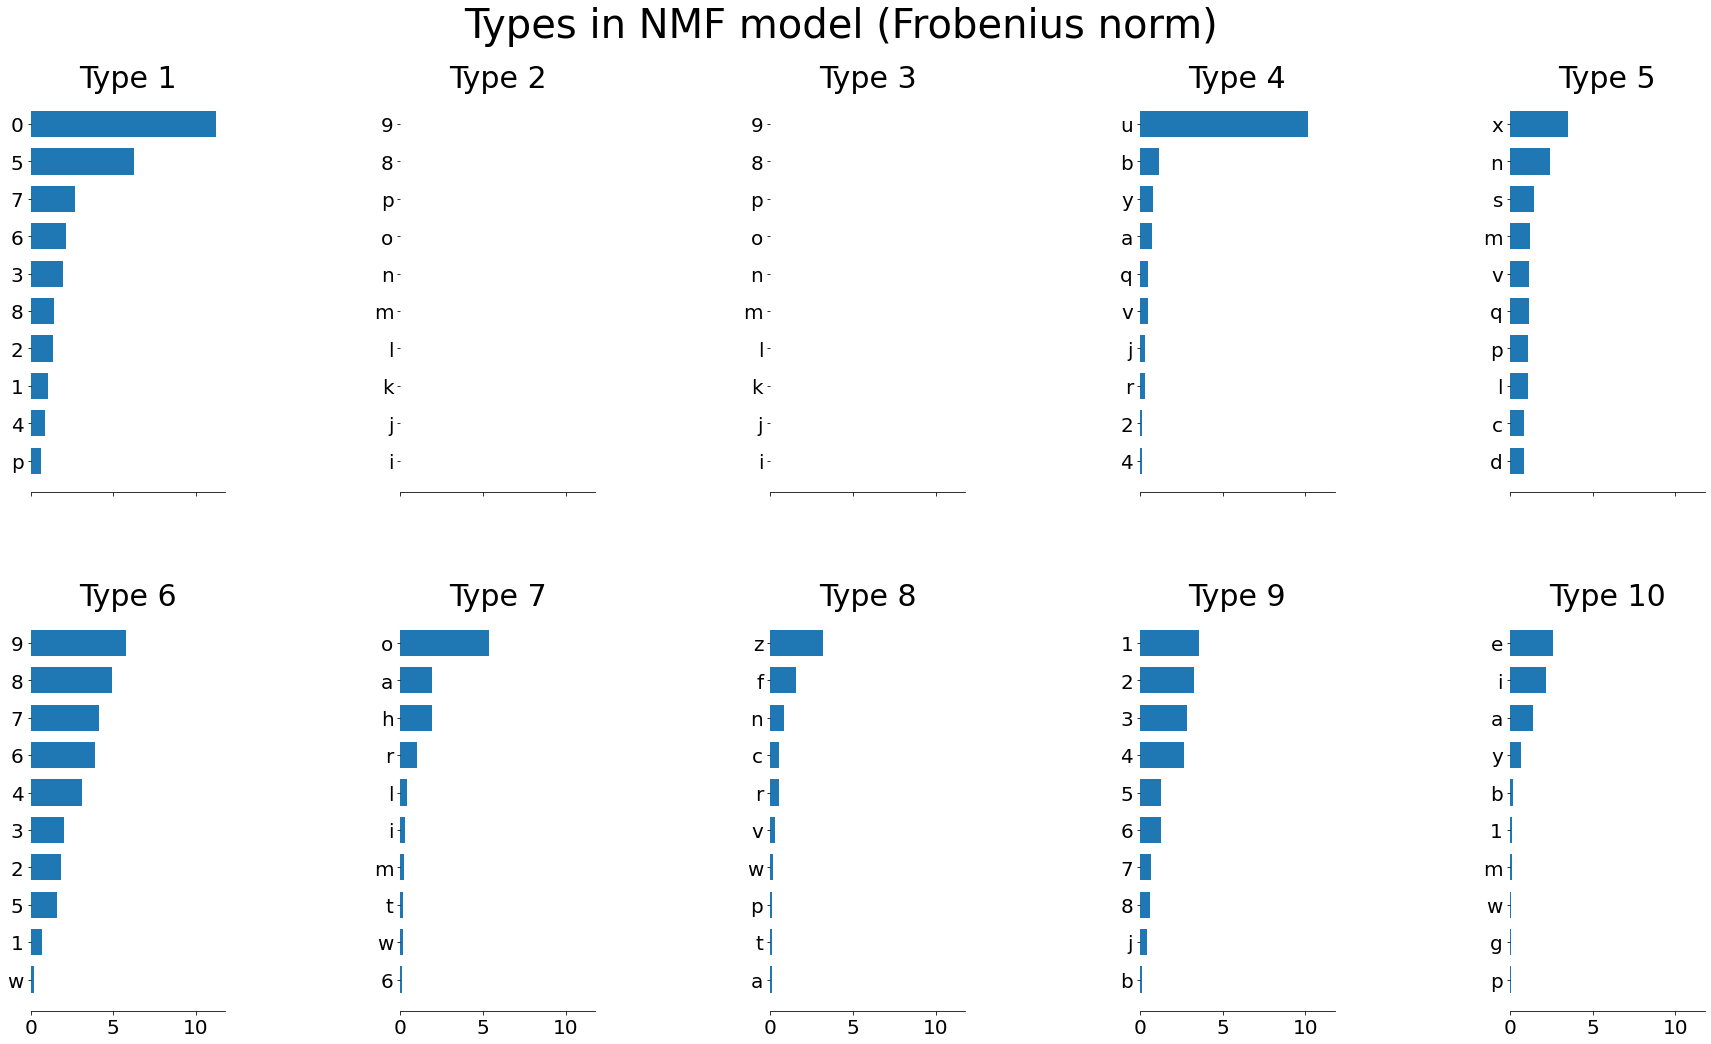

done in 0.698s.


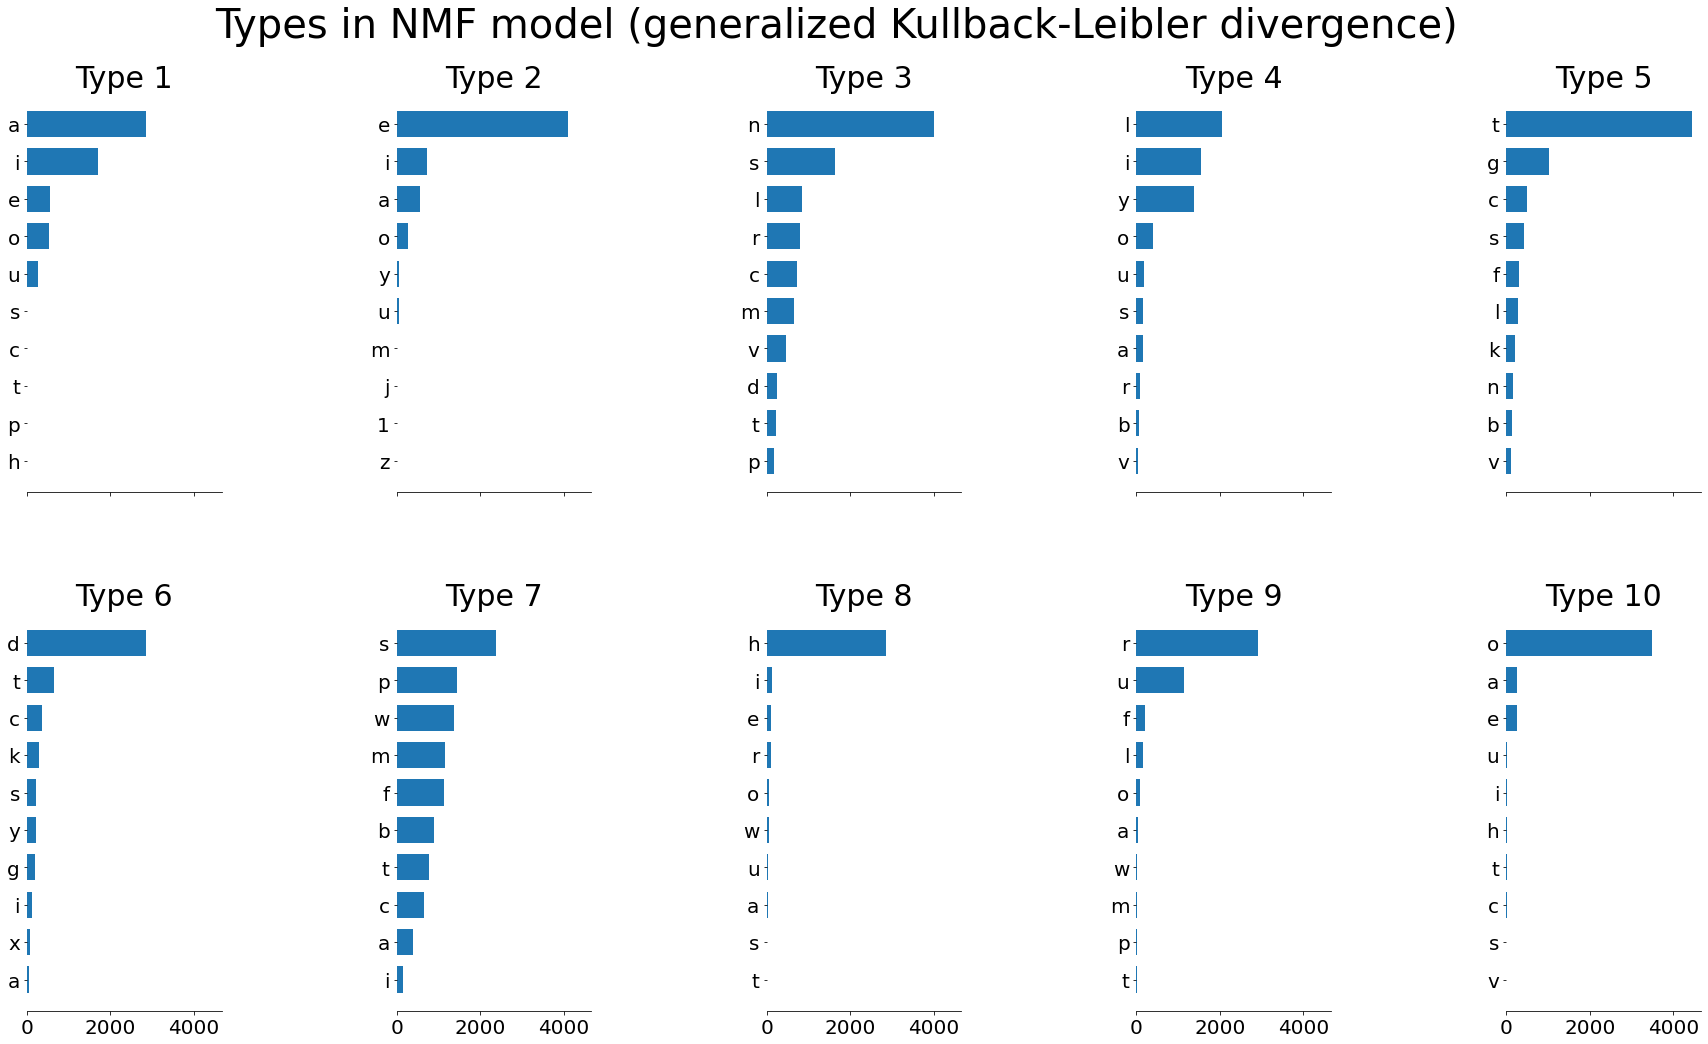

done in 0.088s.


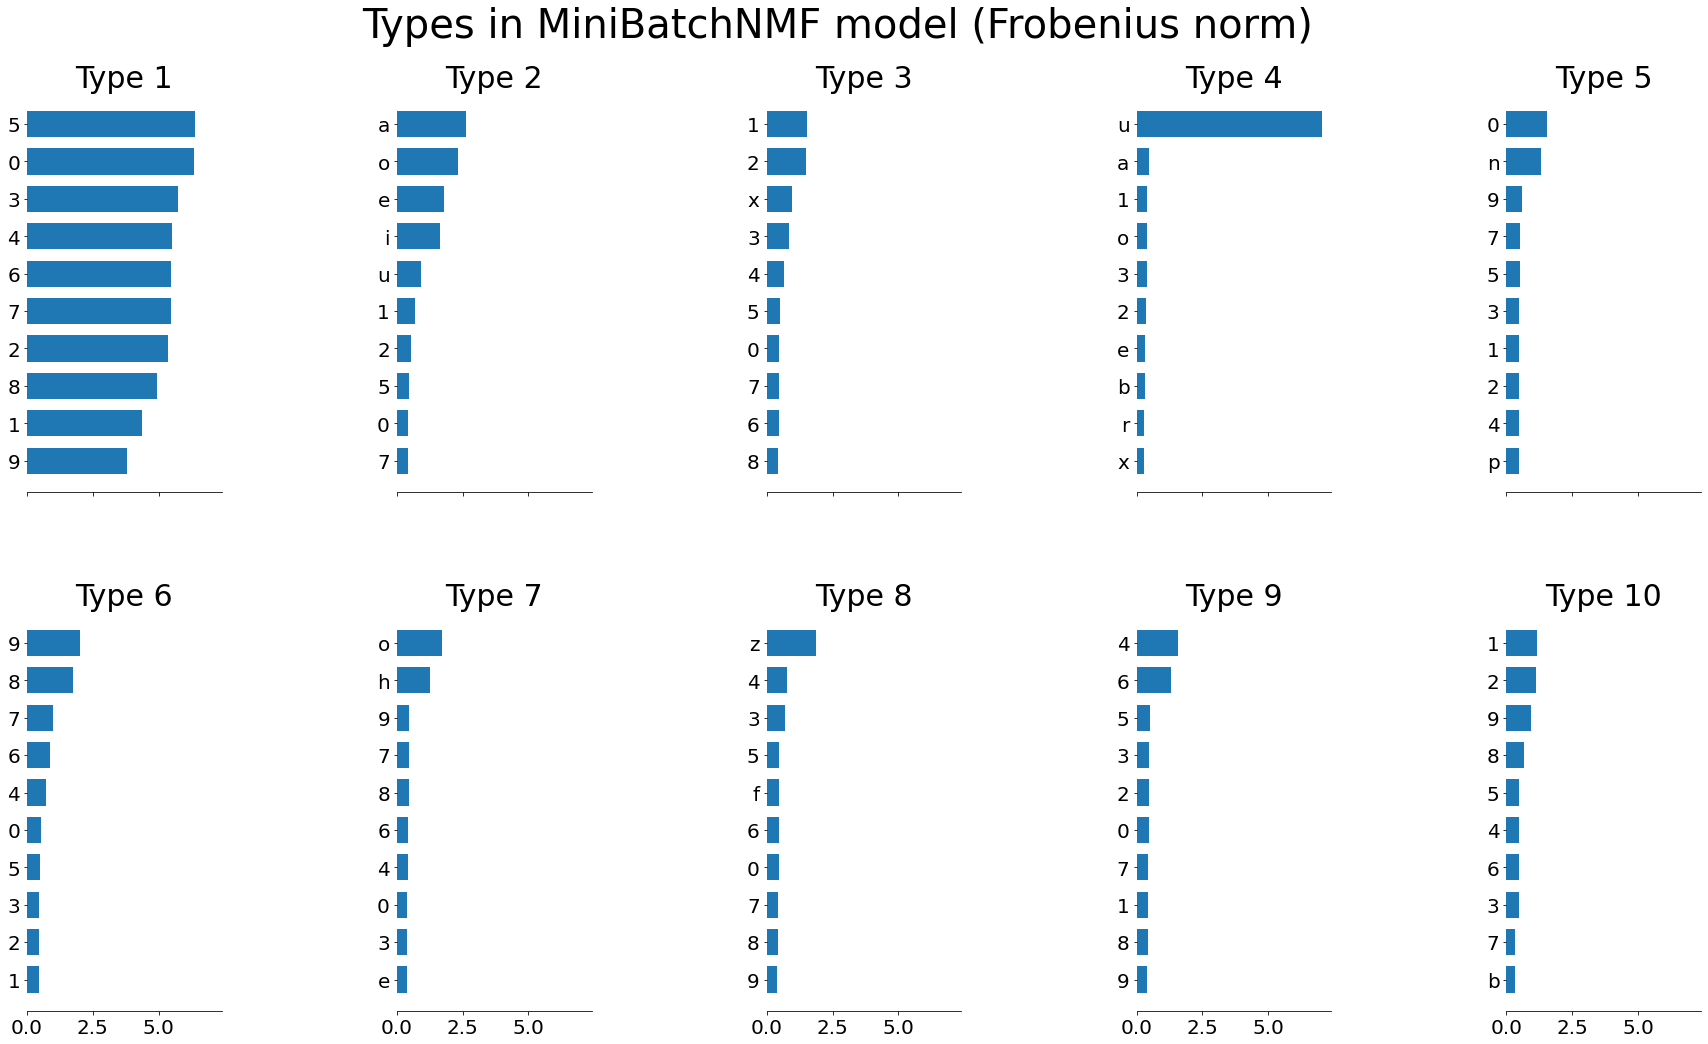

done in 3.914s.


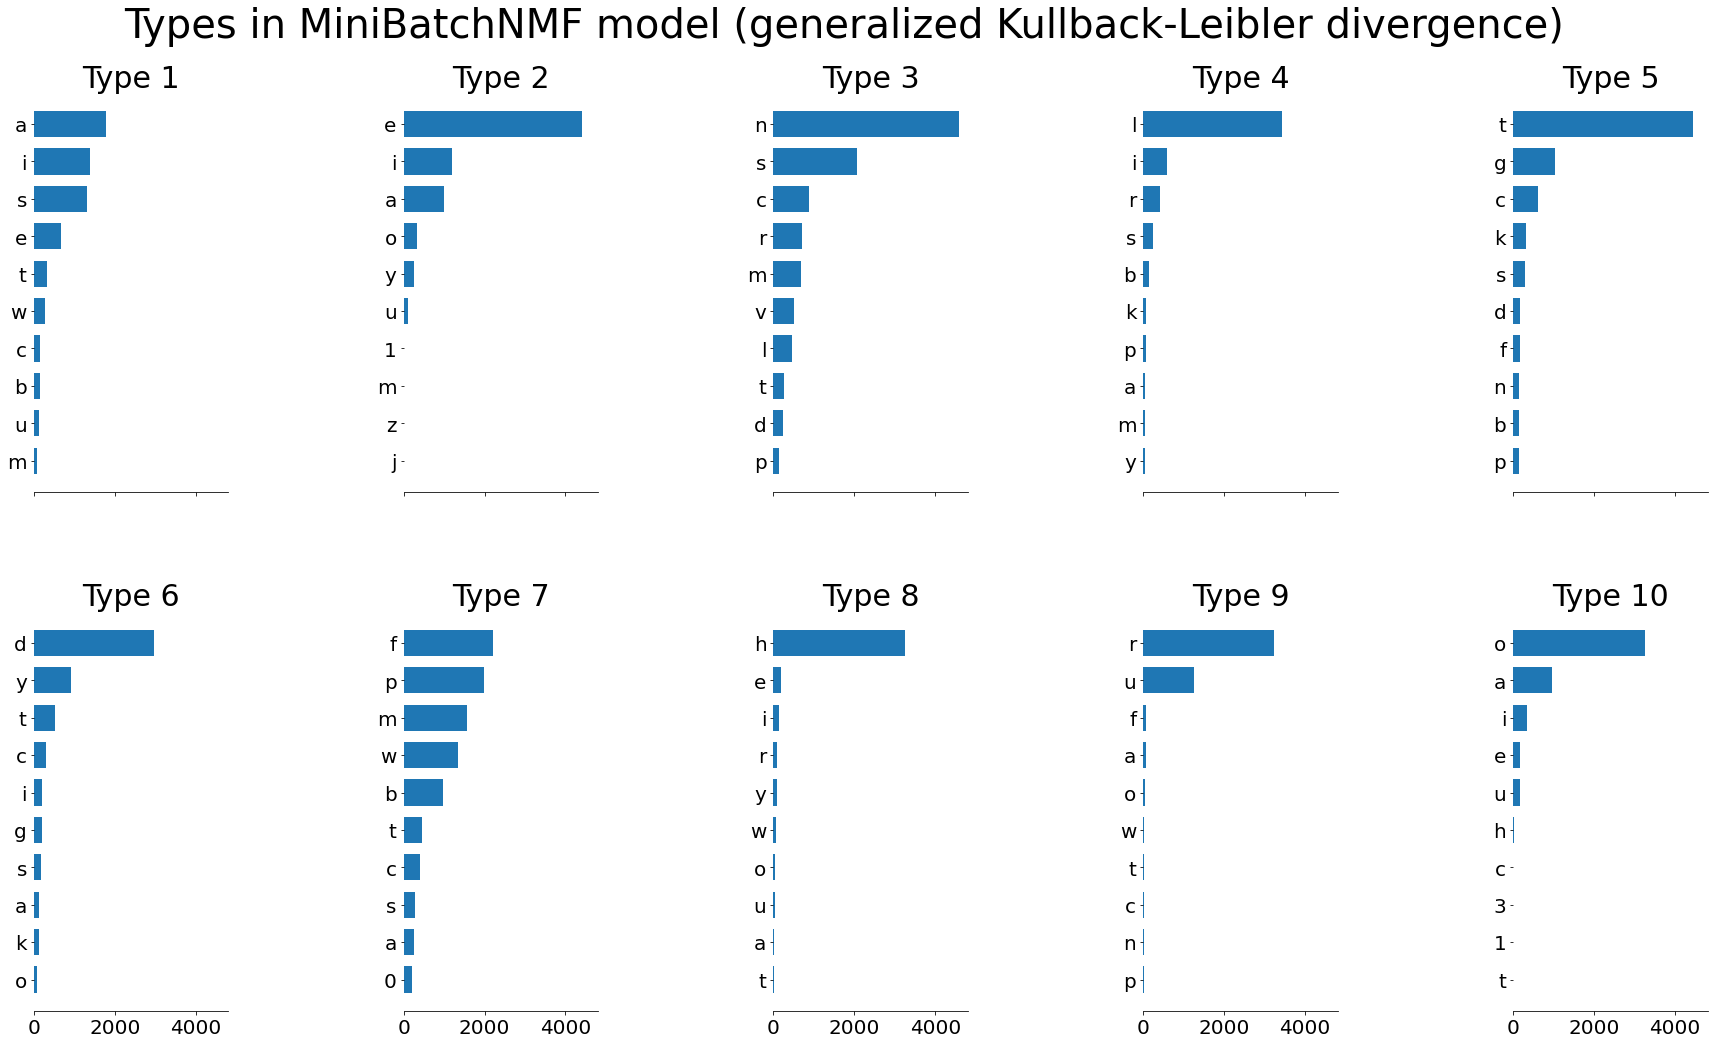

done in 0.248s.


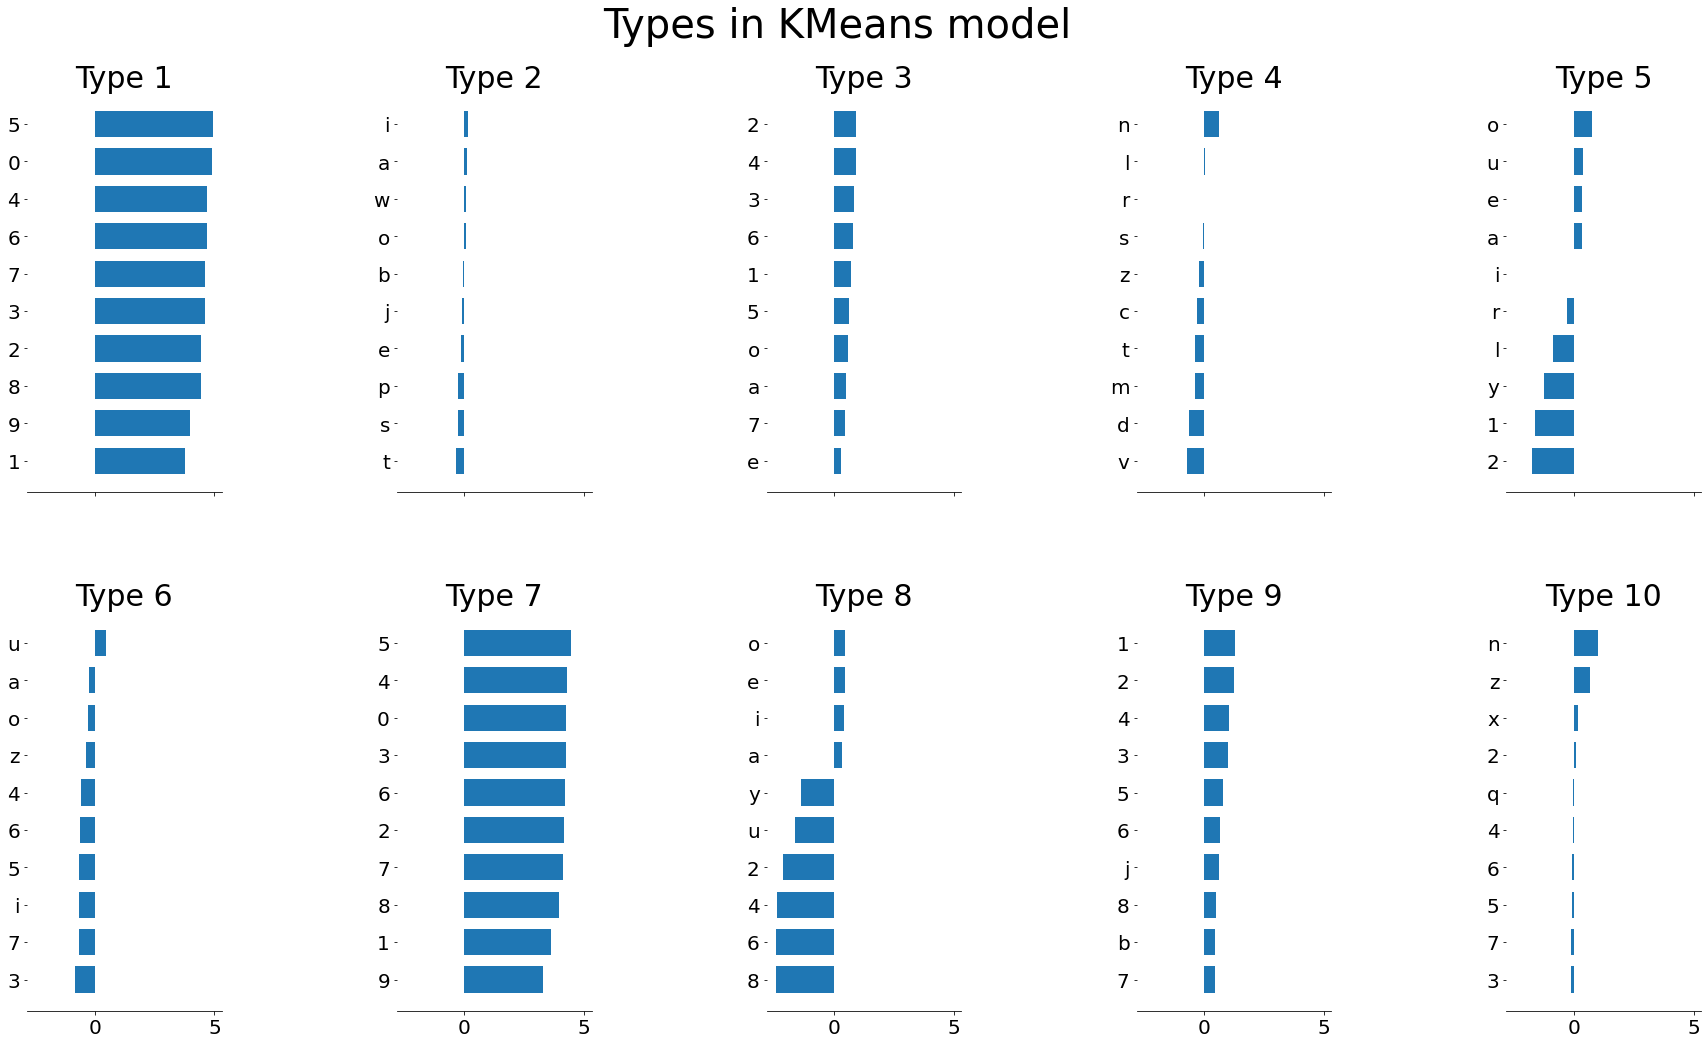

done in 5.678s.


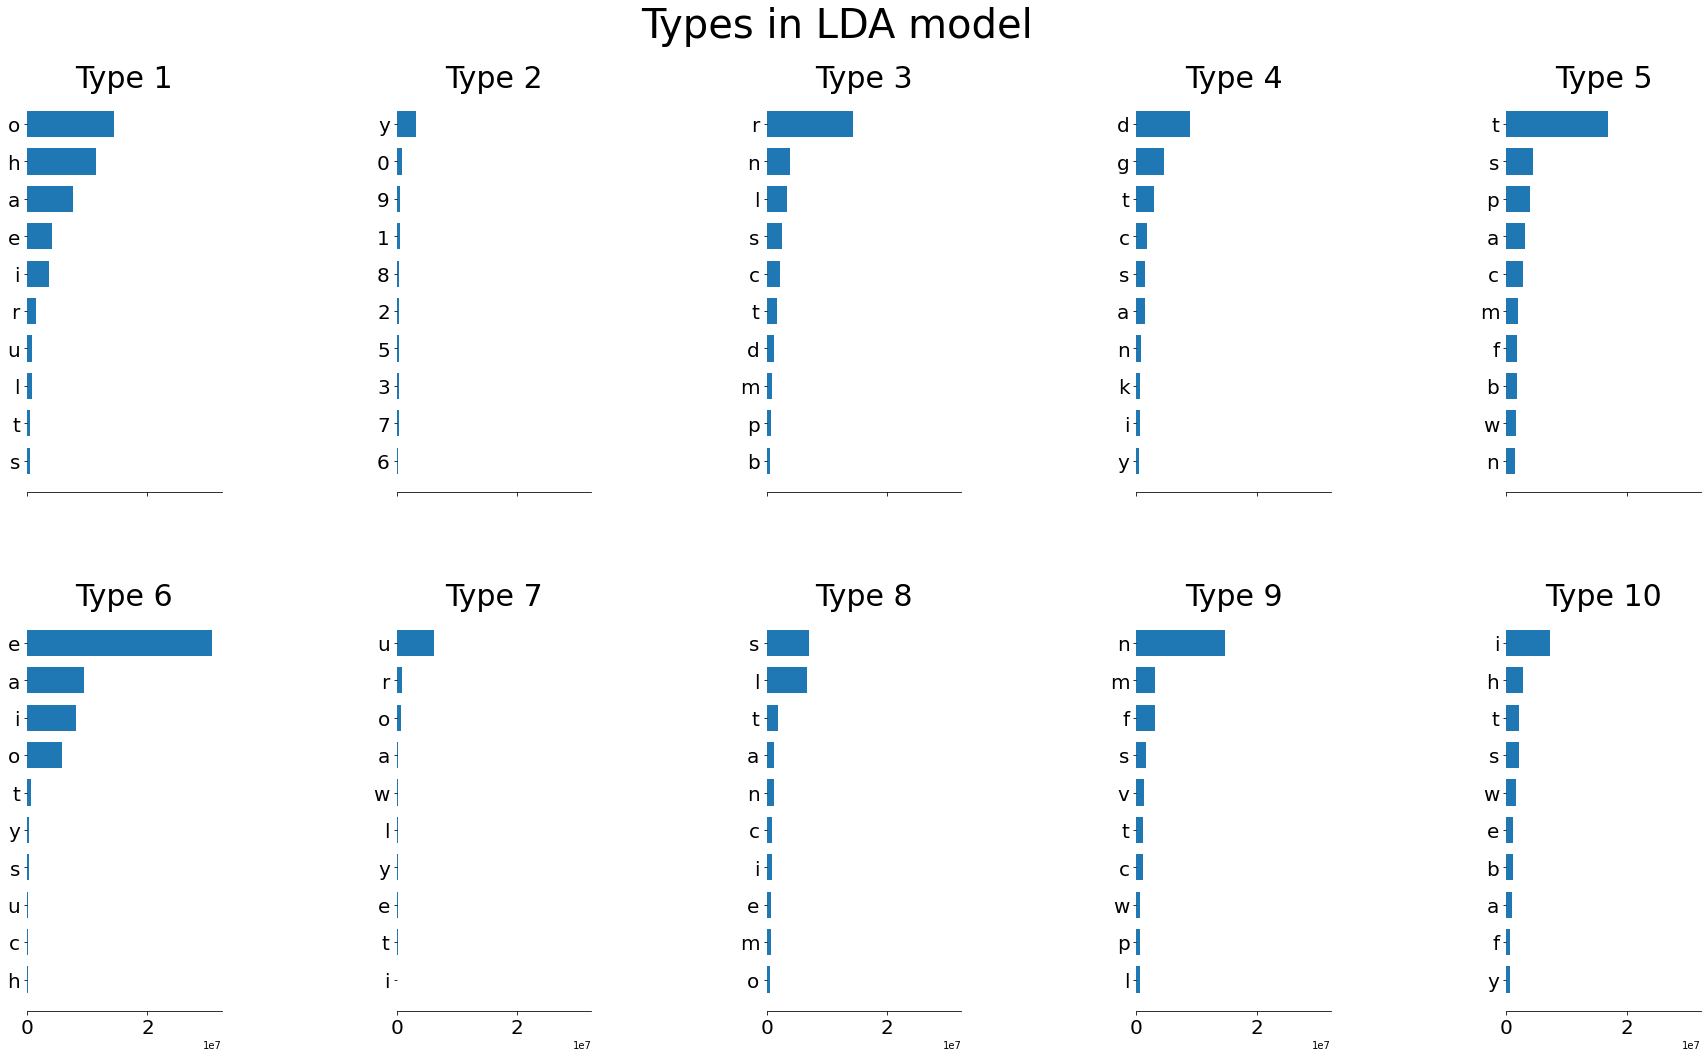

In [9]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.datasets import fetch_20newsgroups

n_features = len(elements)
n_components = 10
n_top_words = 10
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title, n_components):
    rows = math.ceil(n_components/5)
    fig, axes = plt.subplots(rows, 5, figsize=(30, 7.5*rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Type {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(a_M_ppmi)
print("done in %0.3fs." % (time() - t0))


# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names = np.array(elements)

plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Types in NMF model (Frobenius norm)",
    n_components
)


t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(a_M)
print("done in %0.3fs." % (time() - t0))

# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names = np.array(elements)

plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Types in NMF model (generalized Kullback-Leibler divergence)",
    n_components
)

t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(a_M_ppmi)
print("done in %0.3fs." % (time() - t0))


# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names = np.array(elements)

plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Types in MiniBatchNMF model (Frobenius norm)",
    n_components
)

t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(a_M)
print("done in %0.3fs." % (time() - t0))

# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names = np.array(elements)

plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Types in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
    n_components
)

kmeans = KMeans(n_clusters=n_components, random_state=0)
t0 = time()
kmeans.fit(a_M_pmi)
kmeans.components_ = kmeans.cluster_centers_
print("done in %0.3fs." % (time() - t0))

tf_feature_names = np.array(elements)

plot_top_words(
    kmeans,
    tf_feature_names,
    n_top_words,
    "Types in KMeans model",
    n_components
    )


lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(a_M)
print("done in %0.3fs." % (time() - t0))

# tf_feature_names = tf_vectorizer.get_feature_names_out()
tf_feature_names = np.array(elements)


plot_top_words(
    lda,
    tf_feature_names,
    n_top_words,
    "Types in LDA model",
    n_components
    )

In [13]:
context_types_l = normalize(lda.components_,"l2",axis=1).dot(normalize(a_M.T.toarray(),"l2",axis=0))

In [14]:
sns.set(rc = {'figure.figsize':(elements_len,n_components)})
def plot(vector):
    return sns.heatmap(vector, xticklabels=[],yticklabels=list(range(1,n_components+1)))

<AxesSubplot:>

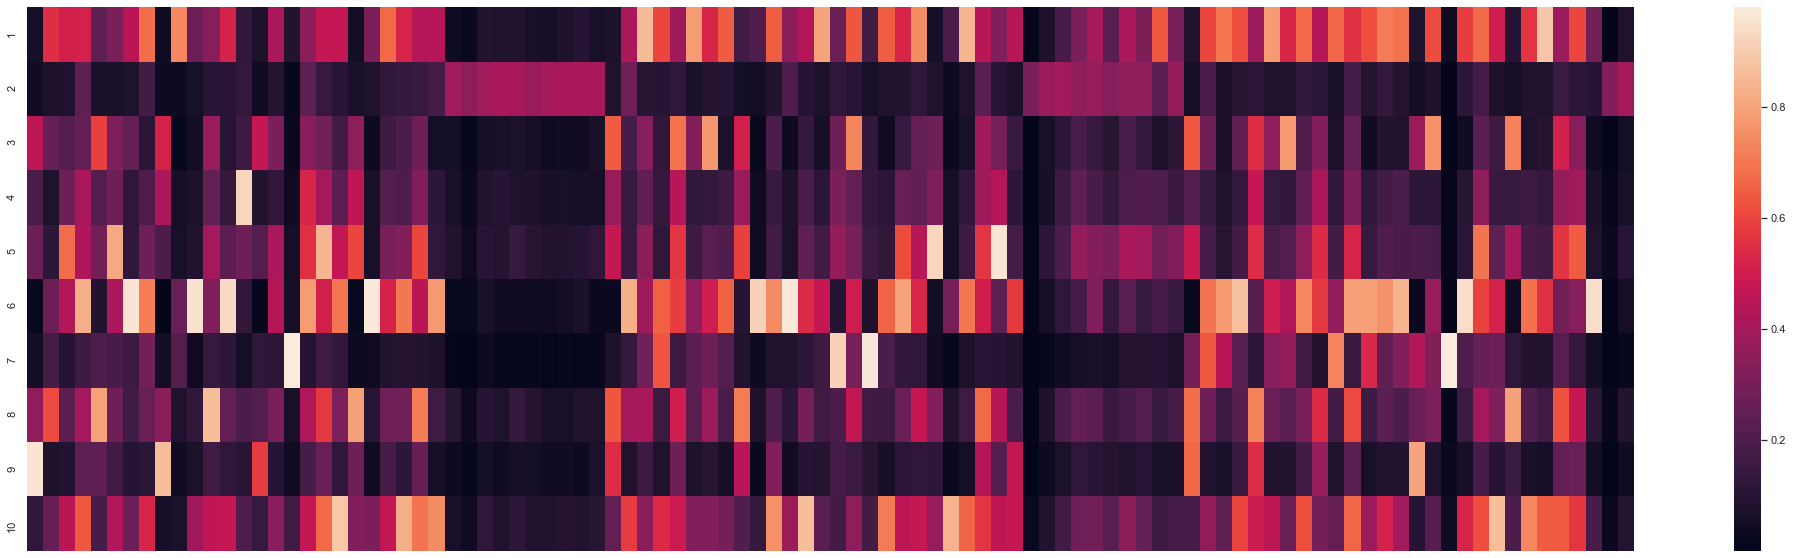

In [15]:
plot(context_types_l[:,:100])